In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re 
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import tree
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [2]:
def data4split(data,test_size=0.1,random_state=123):
    data_nb=data.copy()
    del data_nb['dep_delayed_15min']

    target = data['dep_delayed_15min']

    X_train, X_test, y_train, y_test = train_test_split(data_nb, target, test_size=test_size, random_state=random_state,stratify=target)
    data_eq1 = X_train[y_train==1]
    data_test1=y_train[y_train==1]
    data_eq0 = X_train[y_train==0]
    data_test0=y_train[y_train==0]

    n=int(data_eq0.shape[0]/4)
    rng = np.random.RandomState(seed=123)
    seeds = list(np.arange(4*n))
    rng.shuffle(seeds)
    seed1 = seeds[:n]
    seed2 = seeds[n:2*n]
    seed3 = seeds[2*n:3*n]
    seed4 = seeds[3*n:4*n]
    seed=[seed1,seed2,seed3,seed4]

    data1 = pd.concat([data_eq0.iloc[seed1],data_eq1])
    data2 = pd.concat([data_eq0.iloc[seed2],data_eq1])
    data3 = pd.concat([data_eq0.iloc[seed3],data_eq1])
    data4 = pd.concat([data_eq0.iloc[seed4],data_eq1])
    X_split=[data1,data2,data3,data4]

    test1 = pd.concat([data_test0.iloc[seed1],data_test1])
    test2 = pd.concat([data_test0.iloc[seed2],data_test1])
    test3 = pd.concat([data_test0.iloc[seed3],data_test1])
    test4 = pd.concat([data_test0.iloc[seed4],data_test1])
    y_split=[test1,test2,test3,test4]
    
    return X_split,X_test,y_split,y_test

In [3]:
def get_par_dict(X_data,y_data):
    param_grid = [{'max_depth': [4, 8, 16, 32, 64],   ##字典
                   'max_features': [5,7,10,13,15],
                 'criterion':['gini', 'entropy']}]

    gs = GridSearchCV(estimator=tree.DecisionTreeClassifier(random_state=123),
                      param_grid=param_grid,
                      verbose=0,
                      iid=False,
                      refit=True,
                      scoring='accuracy',
                      cv=5)    ##cv=BootstrapOutOfBag(n_splits=200, random_seed=123))

    gs.fit(X_data,y_data)

    return(gs.best_params_)

In [4]:
def get_feature_list(X_data,y_data,par):
    clf = tree.DecisionTreeClassifier(random_state=123,**par)
    sfs = SFS(clf, k_features=(15,30),
           forward=False, 
           floating=False, 
           verbose=0,
           scoring='accuracy',
           n_jobs=-1,
           cv=4)
    
    feature_names = X_data.columns.tolist()
    sfs = sfs.fit(X_data.values, y_data,custom_feature_names=feature_names)
    nameset = list(sfs.k_feature_names_)
    
    return nameset

In [5]:
datasimple= pd.read_csv('datasimple.csv')

X_split,X_test,y_split,y_test=data4split(datasimple)

y_pred=[0,0,0,0]
y_par = [0,0,0,0]
y_feature = [0,0,0,0]
for i in range(4):
    
    X = X_split[i]
    y = y_split[i]
    par = get_par_dict(X,y)
    
    nameset=get_feature_list(X,y,par)
    
    X_reduce = X.loc[:,nameset]
    
    clf = tree.DecisionTreeClassifier(random_state=123,**par)
    clf.fit(X,y)
    
    y_pred[i] = clf.predict_proba(X_test)
    
    y_par[i] = par
    y_feature[i] = nameset
    
y_comb = (y_pred[0]+y_pred[1]+y_pred[2]+y_pred[3])/4    
y_predict = [0 if i>=0.5 else 1 for i in y_comb[:,0]]

In [6]:
acc = np.mean(y_predict==y_test)
rs=recall_score(y_test, y_predict, labels=True, pos_label=1, average='binary', sample_weight=None)
ps=precision_score(y_test, y_predict, labels=None, pos_label=1, average='binary', sample_weight=None)
f1=f1_score(y_test, y_predict, labels=None, pos_label=1, average='binary', sample_weight=None)
print(' recall_score : ',rs,'\n precision_score : ',ps,'\n f1_score : ',f1,'\n acc : ',acc)

 recall_score :  0.6953781512605042 
 precision_score :  0.2942876194709936 
 f1_score :  0.4135561455567703 
 acc :  0.6245


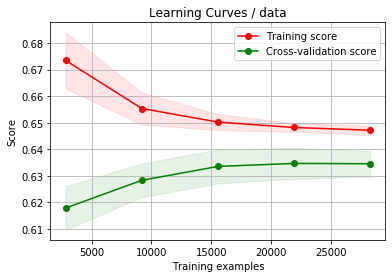

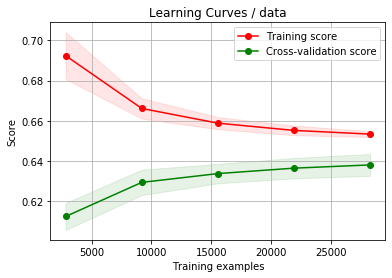

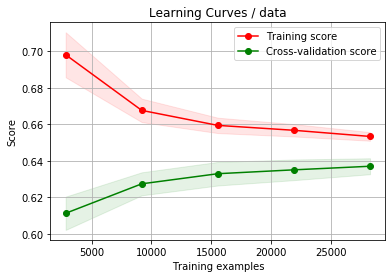

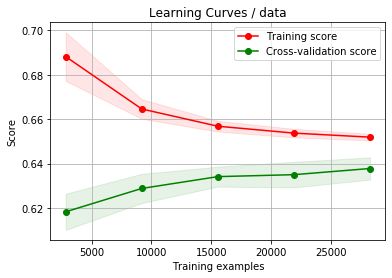

In [7]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5),scoring=None):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

for i in range(4):
    title = "Learning Curves / data"
    cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)
    estimator = tree.DecisionTreeClassifier(random_state=123,**y_par[i])
    plot_learning_curve(estimator, title, X_split[i].loc[:,y_feature[i]], y_split[i], cv=cv, n_jobs=-1,scoring=None)

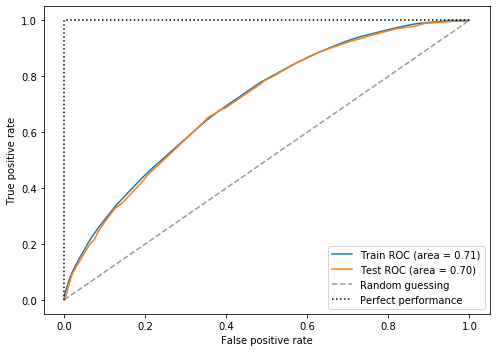

In [8]:
from sklearn.metrics import roc_curve,auc

fig = plt.figure(figsize=(7, 5))
i=0
title = "Learning Curves 2222/data1"
cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)
estimator = tree.DecisionTreeClassifier(random_state=123,**y_par[i])
X_train=X_split[i].loc[:,y_feature[i]]
y_train=y_split[i]
X_test_reduce=X_test.loc[:,y_feature[i]]
#############################################################
### TRAINING ROC CURVE
train_probas = estimator.fit(X_train,
                            y_train).predict_proba(X_train)

fpr, tpr, thresholds = roc_curve(y_train,
                                 train_probas[:, 1],
                                 pos_label=1)
roc_auc = auc(fpr, tpr)

plt.plot(fpr,
         tpr,
         label='Train ROC (area = %0.2f)'
               % (roc_auc))

#############################################################
### TEST ROC CURVE
test_probas = estimator.predict_proba(X_test_reduce)

fpr, tpr, thresholds = roc_curve(y_test,
                                 test_probas[:, 1],
                                 pos_label=1)
roc_auc = auc(fpr, tpr)

plt.plot(fpr,
         tpr,
         label='Test ROC (area = %0.2f)'
               % (roc_auc))
#############################################################

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing')

plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [10]:
y_feature[2]

['Month',
 'DayOfWeek',
 'DepTime',
 'Distance',
 'DepTime_hour',
 'mae_Morning',
 'Dest_type_medium_airport',
 'Origin_type_medium_airport',
 'region_dest_US-AK',
 'region_dest_US-HI',
 'region_dest_US-KY',
 'region_dest_US-ME',
 'region_dest_US-SC',
 'region_dest_US-UT',
 'region_dest_US-WY',
 'region_orig_US-AK',
 'region_orig_US-GA',
 'region_orig_US-ID',
 'region_orig_US-IL',
 'region_orig_US-MT',
 'region_orig_US-SD',
 'region_orig_US-UT',
 'region_orig_US-WY',
 'region_orig_VI-U-A',
 'region_orig_other',
 'ctype_large',
 'ctype_medium']